# Physics Informed Neural Networks

This notebook implements PINNs from Raissi et al. 2017. Specifically, the notebook adapts the code implementation of Data-Driven Solutions of Nonlinear Partial Differential Equations from https://github.com/maziarraissi/PINNs, and the code by Michael Ito, to solve the force-field equation for solar modulation of cosmic rays. Michael Ito's code adaption use the TF2 API where the main mechanisms of the PINN arise in the train_step function efficiently computing higher order derivatives of custom loss functions through the use of the GradientTape data structure. 

In this application, our PINN is $h(r, p) = \frac{\partial f}{\partial r} + \frac{RV}{3k} \frac{\partial f}{\partial p}$ where $k=\beta(p)k_1(r)k_2(r)$ and $\beta = \frac{p}{\sqrt{p^2 + M^2}}$. We will approximate $f(r, p)$ using a neural network.

We have no initial data, but our boundary data will be given by $f(r_{HP}, p) = \frac{J(r_{HP}, T)}{p^2} = \frac{(T+M)^\gamma}{p^2}$, where $r_{HP} = 120$ AU (i.e. the radius of Heliopause), $M=0.938$ GeV, $\gamma$ is between $-2$ and $-3$, and $T = \sqrt{p^2 + M^2} - M$. Or, vice versa, $p = \sqrt{T^2 + 2TM}$.


In [ ]:
# Imports
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import sherpa
import pickle as pkl

tf.config.list_physical_devices(device_type=None)

2022-09-13 16:41:32.659290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/system/CUDA/11.0.2/nvvm/lib64:/opt/apps/software/system/CUDA/11.0.2/extras/CUPTI/lib64:/opt/apps/software/system/CUDA/11.0.2/lib:/opt/apps/software/lib/slurm-drmaa/1.1.3/lib:/opt/apps/software/lib/libevent/2.1.8/lib:/opt/apps/software/devel/PCRE/8.41-GCCcore-7.3.0/lib:/opt/apps/software/lang/Perl/5.28.0-GCCcore-7.3.0/lib:/opt/apps/software/tools/expat/2.2.5-GCCcore-7.3.0/lib:/opt/apps/software/lang/Python/2.7.15-foss-2018b/lib/python2.7/site-packages/numpy-1.14.5-py2.7-linux-x86_64.egg/numpy/core/lib:/opt/apps/software/lang/Python/2.7.15-foss-2018b/lib:/opt/apps/software/lib/libffi/3.2.1-GCCcore-7.3.0/lib64:/opt/apps/software/lib/libffi/3.2.1-GCCcore-7.3.0/lib:/opt/apps/software/math/GMP/6.1.2-GCCcore-7.3.0/lib:/opt/apps/so

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Load the Data

r: (10, 1), p: (10, 1), T: (10, 1), f_boundary: (10, 1), P_star: (100, 2), lb: [[-3.13904026]
 [17.90985512]], ub:[[ 6.9086924 ]
 [23.61363759]]


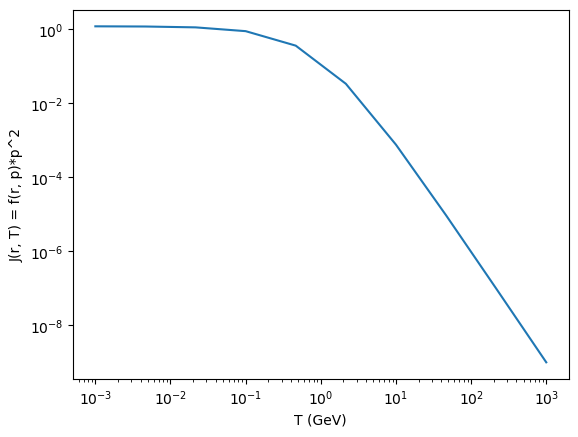

In [ ]:
# Constants  
m = 0.938 # GeV/c^2
gamma = -3 # Between -2 and -3
size = 512 # size of r, T, p, and f_boundary

# Create intial r, p, and T predict data
T = np.logspace(np.log10(0.001), np.log10(1000), size).flatten()[:,None] # GeV
p = (np.sqrt((T+m)**2-m**2)).flatten()[:,None] # GeV/c
r = (np.logspace(np.log10(0.4), np.log10(120), size)*150e6).flatten()[:,None] # km

# Create boundary f data (f at r_HP) for boundary loss
f_boundary = ((T + m)**gamma)/(p**2) # particles/(m^3 (GeV/c)^3)

# Plot
plt.loglog(T, f_boundary*(p**2))
plt.xlabel("T (GeV)")
plt.ylabel("J(r, T) = f(r, p)*p^2")

# Take the log of all input data
r = np.log(r)
T = np.log(T)
p = np.log(p)
f_boundary = np.log(f_boundary)

# Domain bounds
lb = np.array([p[0], r[0]]) # (p, r) in (GeV, AU)
ub = np.array([p[-1], r[-1]]) # (p, r) in (GeV, AU)

# Flatten and transpose data for ML
P, R = np.meshgrid(p, r)
P_star = np.hstack((P.flatten()[:,None], R.flatten()[:,None]))

# Check inputs
print(f'r: {r.shape}, p: {p.shape}, T: {T.shape}, f_boundary: {f_boundary.shape}, P_star: {P_star.shape}, lb: {lb}, ub:{ub}')

## PINN Class

The PINN class subclasses the Keras Model so that we can implement our custom fit and train_step functions.

In [5]:
'''
Description: Defines the class for a PINN model implementing train_step, fit, and predict functions. Note, it is necessary 
to design each PINN seperately for each system of PDEs since the train_step is customized for a specific system. 
This PINN in particular solves the force-field equation for solar modulation of cosmic rays. Once trained, the PINN can predict the solution space given 
domain bounds and the input space. 
'''
class PINN(tf.keras.Model):
    def __init__(self, inputs, outputs, lower_bound, upper_bound, p, r, f_boundary, size, n_samples=20000, n_boundary=50):
        super(PINN, self).__init__(inputs=inputs, outputs=outputs)
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.p = p
        self.r = r
        self.f_boundary = f_boundary
        self.n_samples = n_samples
        self.n_boundary = n_boundary
        self.size = size
        
    '''
    Description: A system of PDEs are determined by 2 types of equations: the main partial differential equations 
    and the boundary value equations. These two equations will serve as loss functions which 
    we train the PINN to satisfy. If a PINN can satisfy BOTH equations, the system is solved. Since there are 2 types of 
    equations (PDE, Boundary Value), we will need 2 types of inputs. Each input is composed of a spatial 
    variable 'r' and a momentum variable 'p'. The different types of (p, r) pairs are described below.
    
    Inputs: 
        p, r: (batchsize, 1) shaped arrays : These inputs are used to derive the main partial differential equation loss.
        Train step first feeds (p, r) through the PINN for the forward propagation. This expression is PINN(p, r) = f. 
        Next, the partials f_p and f_r are obtained. We utilize TF2s GradientTape data structure to obtain all partials. 
        Once we obtain these partials, we can compute the main PDE loss and optimize weights w.r.t. to the loss. 
        
        p_boundary, r_boundary : (boundary_batchsize, 1) shaped arrays : These inputs are used to derive the boundary value
        equations. The boundary value loss relies on target data (**not an equation**), so we can just measure the MAE of 
        PINN(p_boundary, r_boundary) = f_pred_boundary and boundary_f.
        
        f_boundary: (boundary_batchsize, 1) shaped arrays : This is the target data for the boundary value inputs
        
        alpha = weight on pinn_loss
        
        beta = weight on boundary_loss
        
    Outputs: sum_loss, pinn_loss, boundary_loss
    '''
    def train_step(self, p, r, p_boundary, r_boundary, f_boundary, alpha=1, beta=1):
        with tf.GradientTape(persistent=True) as t2: 
            with tf.GradientTape(persistent=True) as t1: 
                # Forward pass P (PINN data)
                P = tf.concat((p, r), axis=1)
                f = self.tf_call(P)

                # Forward pass P_boundary (boundary condition data)
                P_boundary = tf.concat((p_boundary, r_boundary), axis=1)
                f_pred_boundary = self.tf_call(P_boundary)

                # Calculate boundary loss
                boundary_loss = tf.math.reduce_mean(tf.math.abs(f_pred_boundary - f_boundary))

            # Calculate first-order PINN gradients
            f_p = t1.gradient(f, p)
            f_r = t1.gradient(f, r)

            # Calculate resulting loss = PINN loss + boundary loss
            pinn_loss = self.pinn_loss(p, r, f_p, f_r)
            total_loss = alpha*pinn_loss + beta*boundary_loss
        
        # Backpropagation
        gradients = t2.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # Return losses
        return pinn_loss.numpy(), boundary_loss.numpy()
    
    '''
    Description: The fit function used to iterate through epoch * steps_per_epoch steps of train_step. 
    
    Inputs: 
        P_predict: (N, 2) array: Input data for entire spatial and temporal domain. Used for vizualization for
        predictions at the end of each epoch. Michael created a very pretty video file with it. 
        
        alpha = weight on pinn_loss
        
        beta = weight on boundary_loss
        
        batchsize: batchsize for (p, r) in train step
        
        boundary_batchsize: batchsize for (x_lower, t_boundary) and (x_upper, t_boundary) in train step
        
        epochs: epochs
        
        lr: learning rate
        
        size: size of the prediction data (i.e. len(p) and len(r))
        
        save: Whether or not to save the model to a checkpoint every 10 epochs
        
        load_epoch: If -1, a saved model will not be loaded. Otherwise, the model will be 
        loaded from the provided epoch
        
        lr_decay: If -1, learning rate will not be decayed. Otherwise, lr = lr_decay*lr if loss doesn't
        decrease for 3 epochs
        
        weight_change: If -1, alpha will not be changed. Otherwise, alpha = weight_change*alpha if loss 
        doesn't decrease for 3 epochs
    
    Outputs: Losses for each equation (Total, PDE, Boundary Value), and predictions for each epoch.
    '''
    def fit(self, P_predict, alpha=1, beta=1, batchsize=64, boundary_batchsize=16, epochs=20, lr=3e-3, size=256, 
            save=False, load_epoch=-1, lr_decay=-1, weight_change=-1):
        # If load == True, load the weights
        if load_epoch != -1:
            self.load_weights('./ckpts/pinn_epoch_' + str(load_epoch))
        
        # Initialize losses as zeros
        steps_per_epoch = np.ceil(self.n_samples / batchsize).astype(int)
        total_pinn_loss = np.zeros((epochs, ))
        total_boundary_loss = np.zeros((epochs, ))
        predictions = np.zeros((size**2, 1, epochs))
        
        # For each epoch, sample new values in the PINN and boundary areas and pass them to train_step
        for epoch in range(epochs):
            # Compile
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
            self.compile(optimizer=opt)

            # Reset loss variables
            sum_loss = np.zeros((steps_per_epoch,))
            pinn_loss = np.zeros((steps_per_epoch,))
            boundary_loss = np.zeros((steps_per_epoch,))
            
            # For each step, get PINN and boundary variables and pass them to train_step
            for step in range(steps_per_epoch):
                # Get PINN p and r variables via uniform distribution sampling between lower and upper bounds
                p = tf.Variable(tf.random.uniform((batchsize, 1), minval=self.lower_bound[0], maxval=self.upper_bound[0]))
                r = tf.Variable(tf.random.uniform((batchsize, 1), minval=self.lower_bound[1], maxval=self.upper_bound[1]))
                
                # Randomly sample boundary_batchsize from p_boundary and f_boundary
                p_idx = np.expand_dims(np.random.choice(self.f_boundary.shape[0], boundary_batchsize, replace=False), axis=1)
                p_boundary = self.p[p_idx]
                f_boundary = self.f_boundary[p_idx]
                
                # Create r_boundary array = r_HP
                upper_bound = np.zeros((boundary_batchsize, 1))
                upper_bound[:] = self.upper_bound[1]
                r_boundary = tf.Variable(upper_bound, dtype=tf.float32)
                
                # Pass variables through the model via train_step and get losses
                losses = self.train_step(p, r, p_boundary, r_boundary, f_boundary, alpha, beta)
                pinn_loss[step] = losses[0]
                boundary_loss[step] = losses[1]
            
            # Calculate and print total losses for the epoch
            total_pinn_loss[epoch] = np.sum(pinn_loss)
            total_boundary_loss[epoch] = np.sum(boundary_loss)
            print(f'Training loss for epoch {epoch}: pinn: {total_pinn_loss[epoch]:.4f}, boundary: {total_boundary_loss[epoch]:.4f}, total: {(total_boundary_loss[epoch]+total_pinn_loss[epoch]):.4f}')
            
            # Predict
            predictions[:, :, epoch] = self.predict(P_predict, size)
            
            # If the epoch is a multiple of 10, save to a checkpoint
            if (epoch%10 == 0) & (save == True):
                self.save_weights('./ckpts/pinn_epoch_' + str(epoch), overwrite=True, save_format=None, options=None)
            
            # Determine if loss has decreased for the past 2 or 5 epochs
            if (epoch > 3):
                isDecreasingFor2 = False
                for i in range(2):
                    if (total_pinn_loss[epoch-i] + total_boundary_loss[epoch-i]) < (total_pinn_loss[epoch-(i+1)] + total_boundary_loss[epoch-(i+1)]):
                        isDecreasingFor2 = True
                        
                # If loss hasn't decreased for the past 2 epochs, decrease lr by lr_decay
                if (lr_decay != -1) & (not isDecreasingFor2):
                    lr = lr_decay*lr

                # If pinn loss hasn't decreased for the past 2 epochs, increase alpha by weight_change
                if (weight_change != -1) & (not isDecreasingFor2):
                    alpha = weight_change*alpha
                    print("Increased fo 2! new alpha: ", alpha)
            
            if (epoch > 6):
                isDecreasingFor5 = False
                for i in range(5):
                    if (total_pinn_loss[epoch-i] + total_boundary_loss[epoch-i]) < (total_pinn_loss[epoch-(i+1)] + total_boundary_loss[epoch-(i+1)]):
                        isDecreasingFor5 = True
                        
                # If loss hasn't decreased for 5 epochs, break
                if not isDecreasingFor5:
                    break
        
        # Return epoch losses
        return total_pinn_loss, total_boundary_loss, predictions
    
    # Predict for some P's the value of the neural network f(r, p)
    def predict(self, P, size, batchsize=2048):
        steps_per_epoch = np.ceil(P.shape[0] / batchsize).astype(int)
        preds = np.zeros((size**2, 1))
        
        # For each step calculate start and end index values for prediction data
        for step in range(steps_per_epoch):
            start_idx = step * 64
            
            # If last step of the epoch, end_idx is shape-1. Else, end_idx is start_idx + 64 
            if step == steps_per_epoch - 1:
                end_idx = P.shape[0] - 1
            else:
                end_idx = start_idx + 64
                
            # Pass prediction data through the model
            preds[start_idx:end_idx, :] = self.tf_call(P[start_idx:end_idx, :]).numpy()
        
        # Return f
        return preds
    
    def evaluate(self, ): 
        pass
    
    # pinn_loss calculates the PINN loss by calculating the MAE of the pinn function
    @tf.function
    def pinn_loss(self, p, r, f_p, f_r): 
        # Note: p and r are taken out of logspace for the PINN calculation
        p = tf.math.exp(p) # GeV/c
        r = tf.math.exp(r) # km
        V = 400 # 400 km/s
        m = 0.938 # GeV/c^2
        k_0 = 1e11 # km^2/s
        k_1 = k_0 * tf.math.divide(r, 150e6) # km^2/s
        k_2 = p # unitless, k_2 = p/p0 and p0 = 1 GeV/c
        R = p # GV
        beta = tf.math.divide(p, tf.math.sqrt(tf.math.square(p) + tf.math.square(m))) 
        k = beta*k_1*k_2
        
        # Calculate physics loss
        l_f = tf.math.reduce_mean(tf.math.abs(f_r + (tf.math.divide(R*V, 3*k) * f_p)))
        
        return l_f
    
    # tf_call passes inputs through the neural network
    @tf.function
    def tf_call(self, inputs): 
        return self.call(inputs, training=True)

## Train neural network regularly

In [8]:
# Neural network. Note: 2 inputs- (p, r), 1 output- f(r, p)
inputs = tf.keras.Input((2))
x_ = tf.keras.layers.Dense(100, activation='relu')(inputs)
x_ = tf.keras.layers.Dense(100, activation='relu')(x_)
outputs = tf.keras.layers.Dense(1, activation='linear')(x_) 

# Hyperparameters
alpha = 1 # pinn_loss weight
beta = 1 # boundary_loss weight
lr = 3e-3
lr_decay = 0.9
batchsize = 1032
boundary_batchsize = 256 
epochs = 500
save = False
load_epoch = -1
weight_change = 1.01
    
# Initialize and fit the PINN
pinn = PINN(inputs=inputs, outputs=outputs, lower_bound=lb, upper_bound=ub, p=p[:, 0], r=r[:, 0], 
            f_boundary=f_boundary[:, 0], size=size)
pinn_loss, boundary_loss, predictions = pinn.fit(P_predict=P_star, alpha=alpha, beta=beta, batchsize=batchsize, 
                                                 boundary_batchsize=boundary_batchsize, epochs=epochs, lr=lr, size=size, 
                                                 save=save, load_epoch=load_epoch, lr_decay=lr_decay, weight_change=weight_change)

Training loss for epoch 0: pinn: 2.1531, boundary: 145.1537, total: 147.3067
Training loss for epoch 1: pinn: 3.9974, boundary: 45.5742, total: 49.5716
Training loss for epoch 2: pinn: 3.8040, boundary: 39.9033, total: 43.7073
Training loss for epoch 3: pinn: 3.7477, boundary: 42.7817, total: 46.5295
Training loss for epoch 4: pinn: 3.7616, boundary: 45.2689, total: 49.0305
Increased fo 2! new alpha:  1.1
Training loss for epoch 5: pinn: 3.2479, boundary: 32.5888, total: 35.8366
Training loss for epoch 6: pinn: 2.6857, boundary: 26.5467, total: 29.2324
Training loss for epoch 7: pinn: 2.7154, boundary: 25.4784, total: 28.1938
Training loss for epoch 8: pinn: 2.9382, boundary: 31.0240, total: 33.9622
Training loss for epoch 9: pinn: 2.3647, boundary: 20.7304, total: 23.0951
Training loss for epoch 10: pinn: 2.6411, boundary: 28.2394, total: 30.8805
Training loss for epoch 11: pinn: 2.5738, boundary: 25.6194, total: 28.1932
Training loss for epoch 12: pinn: 2.2597, boundary: 21.4406, tot

## Save the outputs to a pickle

In [5]:
# Save PINN outputs
with open('./figures/pinn_loss.pkl', 'wb') as file:
    pkl.dump(pinn_loss, file)
    
with open('./figures/boundary_loss.pkl', 'wb') as file:
    pkl.dump(boundary_loss, file)
    
with open('./figures/predictions.pkl', 'wb') as file:
    pkl.dump(predictions, file)
    
with open('./figures/f_boundary.pkl', 'wb') as file:
    pkl.dump(f_boundary, file)
    
with open('./figures/p.pkl', 'wb') as file:
    pkl.dump(p, file)
    
with open('./figures/T.pkl', 'wb') as file:
    pkl.dump(T, file)
    
with open('./figures/r.pkl', 'wb') as file:
    pkl.dump(r, file)

## Train neural network with Sherpa

In [ ]:
# # Set-up sherpa parameters, algorithm, and study
# parameters = [sherpa.Ordinal(name='beta', range=[5, 10, 15, 20, 30]),
#               sherpa.Continuous(name='lr', range=[3e-5, 3e-1], scale='log'),
#               sherpa.Ordinal(name='batchsize', range=[256, 512, 1032, 2048]),
#               sherpa.Ordinal(name='boundary_batchsize', range=[64, 128, 256]),
#               sherpa.Ordinal(name='num_hidden_units', range=[100, 500, 1000]),
#               sherpa.Choice(name='activation', range=['relu', 'tanh'])]

# algorithm = sherpa.algorithms.RandomSearch(max_num_trials=2)

# study = sherpa.Study(parameters=parameters,
#                  algorithm=algorithm,
#                  lower_is_better=True)

# num_iterations = 1

# # For each trial in the study, fit the model on the parameters and add the observation to the study
# for trial in study:
#     # Define neural network
#     inputs = tf.keras.Input((2))
#     x_ = tf.keras.layers.Dense(trial.parameters, activation=trial.parameters[5])(inputs)
#     x_ = tf.keras.layers.Dense(trial.parameters[4], activation=trial.parameters[5])(x_)
#     outputs = tf.keras.layers.Dense(1, activation='linear')(x_) 

#     # Initialize PINN and compile
#     pinn = PINN(inputs=inputs, outputs=outputs, lower_bound=lb, upper_bound=ub, p=p[:, 0], r=r[:, 0], 
#             f_boundary=f_boundary[:, 0], size=size)
#     optimizer=tf.keras.optimizers.Adam(learning_rate=trial.parameters[1])
#     pinn.compile(optimizer=optimizer)
    
#     # For each iteration, fit the PINN and add the observation to the study
#     for iteration in range(num_iterations):
#         total_loss, pinn_loss, boundary_loss, predictions = pinn.fit(P_predict=P_star, alpha=alpha, beta=trial.parameters[0], batchsize=trial.parameters[2], 
#                                                              boundary_batchsize=trial.parameters[3], epochs=100, size=size)
#         study.add_observation(trial=trial,
#                               iteration=iteration,
#                               objective=boundary_loss,
#                               context={'boundary_loss': boundary_loss})
#     study.finalize(trial)